<a href="https://colab.research.google.com/github/chavgova/predictNeuron_honor/blob/main/model_lstm_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import scipy.io
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

Load Data

In [2]:
label_data_folder = "/content/drive/MyDrive/Single channels data/Marked spike vectors"
raw_data_folder = "/content/drive/MyDrive/Single channels data/28102021_03_01_nbasal_0001/data"

In [3]:
os.chdir(raw_data_folder)
mat_files = glob.glob("*.mat")

data_dict = {}

for file in mat_files[:20]:
    # Load the .mat file using scipy.io.loadmat
    mat = scipy.io.loadmat(file)
    data_dict[file[27:30]] = np.concatenate(mat['data'])

print(data_dict.keys())
raw_df = pd.DataFrame.from_dict(data_dict, orient='columns')
raw_df

dict_keys(['A02', 'A05', 'A03', 'B07', 'B06', 'B01', 'B03', 'A06', 'B02', 'B05', 'C06', 'C03', 'C02', 'C05', 'C04', 'C01', 'D01', 'C07', 'D03', 'D02'])


,A02,A05,A03,B07,B06,B01,B03,A06,B02,B05,C06,C03,C02,C05,C04,C01,D01,C07,D03,D02
0,-1.921908,-4.485947,2.472312,-1.004966,2.960513,1.983918,1.373807,-2.959032,0.274880,-0.762878,0.031140,3.020819,5.462379,-2.471503,-1.556942,0.885219,-0.762241,-1.067851,0.336652,-5.341440
1,-1.250521,-6.561143,1.007469,-3.202231,0.824282,3.326691,1.495877,0.886183,-0.030296,1.190247,0.580456,2.959784,4.119606,-2.898749,-0.641415,-1.312047,-3.569858,-0.152323,2.106672,-4.609018
2,0.397428,-4.546983,2.167137,-1.981528,-1.311948,3.814972,1.312772,0.519972,-1.861351,1.922668,1.251843,0.335272,1.617165,2.167169,-1.556942,-3.875523,-0.823276,-5.889628,-0.212664,-2.716929
3,-4.546420,-3.936631,4.242332,-4.911216,-0.884702,4.364289,-2.166232,1.557570,-1.983421,0.274719,-0.701282,-3.448907,0.457497,1.190607,2.532413,-4.852086,-8.208530,1.922872,0.214582,1.921743
4,-2.715365,-7.415635,4.181297,-2.103599,3.815005,1.068390,3.449002,-0.334520,0.702126,4.791321,-0.884388,2.532538,-1.190453,0.397150,-0.641415,1.800746,0.397427,0.458028,-0.212664,-1.130015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998995,0.153287,-1.006944,-2.532570,-0.821860,3.021548,3.143586,0.641385,-10.893602,1.983864,1.190247,-3.203724,-2.777521,-4.486351,-7.110175,2.715519,4.059047,0.397427,5.218770,-0.639910,1.799673
2998996,0.763639,-2.166612,-3.326027,5.281655,3.143618,1.922882,3.937284,-13.579149,4.547340,-2.349793,-2.410267,-3.387872,1.434059,-5.645331,0.029972,2.838344,-4.058139,5.829122,2.717023,3.020376
2998997,1.801236,-1.067979,-0.640481,0.765054,2.716372,-1.800262,-2.288302,-5.888719,-2.227562,-3.021179,-5.095814,-3.815118,-0.763207,-8.513983,-0.519344,-1.556187,-2.837436,2.716329,-5.034441,1.311392
2998998,5.097135,-9.979112,0.580223,0.398843,-0.884702,0.763215,-2.776583,2.534132,-0.701683,-2.471863,-5.645130,-0.763361,-1.068382,-9.673651,-6.867001,-3.997594,0.214322,7.171895,-1.189227,-2.533823


Absolute values of the raw data

In [4]:
#raw_df = raw_df.abs()

*   0 - no spike
*   1 - spike


example data

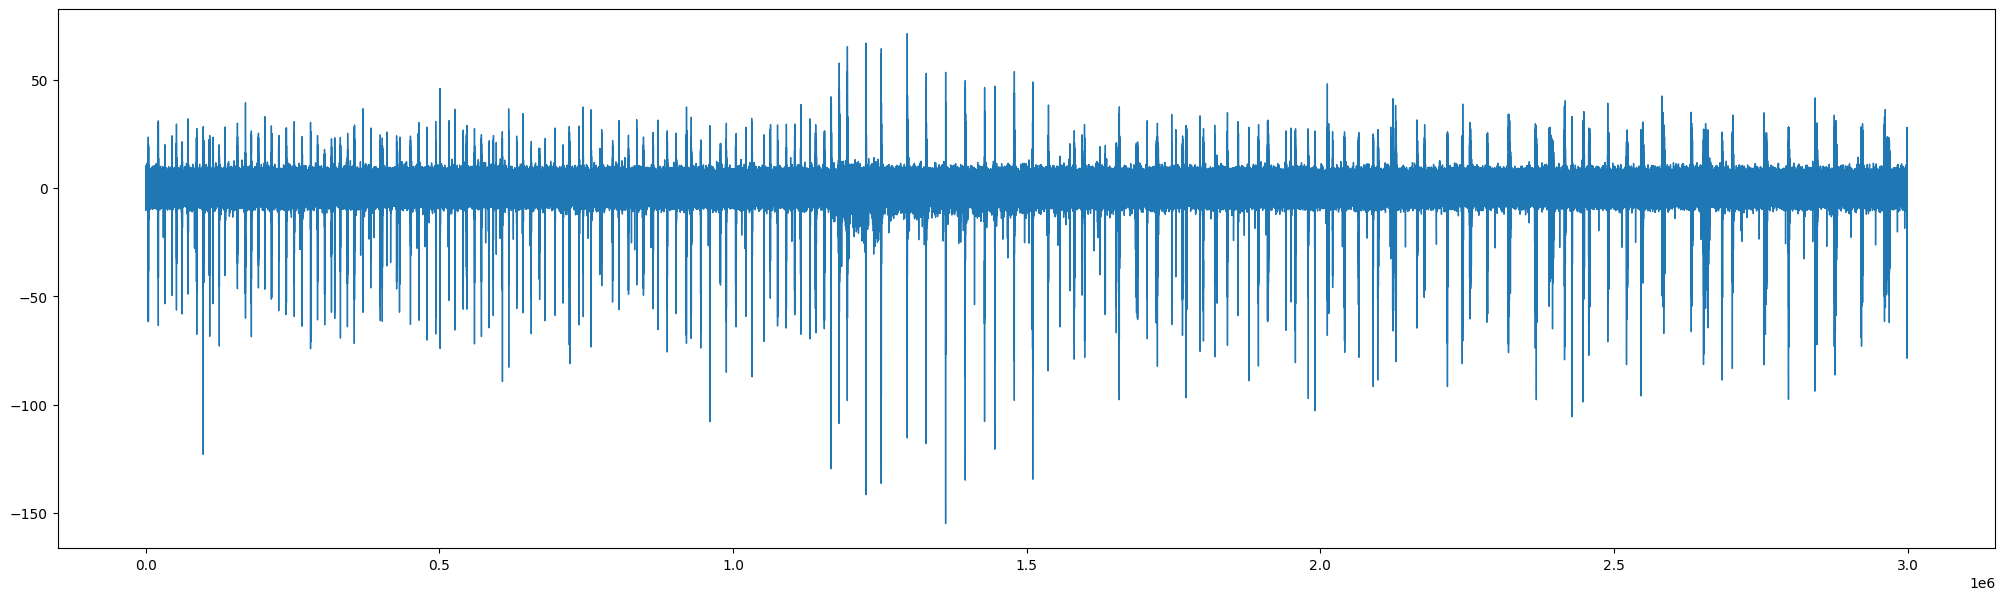

In [5]:
plt.figure(figsize=(25,7))
plt.plot(raw_df['A06'], linewidth = 1)
plt.show()

# Data Pre-Processing

variables

In [6]:
neurons = ['B01', 'B03', 'A06', 'B02', 'B05', 'C06', 'C03', 'C02', 'C05', 'C04', 'A02', 'A05'] # neurons data , 'B07', 'C01', 'A03', 'D01', 'B06', 'C07'

n_data_points = 3 # number of data points considered for training # V n=2, 1<t<10
t_data_points = 3 # number of FUTURE data points in which is predicted if there is a spike or no

In [7]:
raw_df = raw_df[neurons]

raw_data = raw_df.values.T

raw_data.shape

(12, 2999000)

In [8]:
# scaler = StandardScaler()
# raw_data = scaler.fit_transform(raw_data)

Split RAW data; Input-Output

In [9]:
smaller_parts = []
samp = []

labels = []

# Split each sample into smaller parts
for sample in range(0, raw_data.shape[0]):  # Transpose the array to iterate over samples
    num_parts = raw_data[sample].shape[0] // n_data_points
    for i in range(num_parts-1):
        raw_part = raw_data[sample][i * n_data_points: (i + 1) * n_data_points]
        smaller_parts.append(raw_part)
        future = raw_data[sample][(i + 1) * n_data_points : ((i + 1) * n_data_points + t_data_points)]
        labels.append(future)

# Convert the list of smaller parts to a NumPy array
raw_split_data = np.array(smaller_parts)
labels = np.array(labels)

raw_split_data.shape, labels.shape

((11995980, 3), (11995980, 3))

In [10]:
labels

array([[ 4.36428875,  1.06839031,  3.69290203],
       [-1.92233235, -0.94576985,  2.71633953],
       [-0.76266438,  1.67874187,  0.88528484],
       ...,
       [ 1.92274392,  1.98377908, -2.83799827],
       [-3.26524436,  0.09168923,  0.64100564],
       [-1.00694358, -2.16661155, -1.06797873]])

# Test-Train split
wirth the same ratio of 0s and 1s in test and train data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(raw_split_data, labels, test_size=0.2, random_state=13)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9596784, 3)
X_test shape: (2399196, 3)
y_train shape: (9596784, 3)
y_test shape: (2399196, 3)


In [12]:
y_test[143]

array([ 0.64109045, -0.88478846, -2.59377283])

# Model

In [13]:
model = Sequential()
model.add(LSTM(16, input_shape=(n_data_points, 1), return_sequences=True))  # First LSTM layer with 16 units
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(8, activation='tanh'))
model.add(Dense(t_data_points, activation='linear'))  # Output layer with 5 neurons and sigmoid activation (binary classification)

model.compile(optimizer='adam', loss='mse')  # Binary cross-entropy loss for binary classification #  metrics=['accuracy']

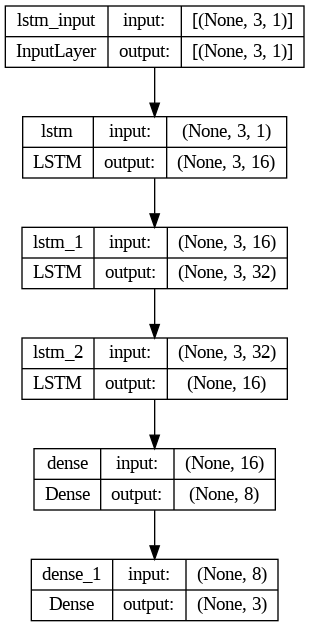

In [14]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

tf.keras.utils.plot_model(model, show_shapes=True)

class_weight=class_weights,

In [15]:
history_model = model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/3
299900/299900 [==============================] - 2806s 9ms/step - loss: 7.9190 - val_loss: 7.6954
Epoch 2/3
299900/299900 [==============================] - 2824s 9ms/step - loss: 7.6583 - val_loss: 7.5339
Epoch 3/3
299900/299900 [==============================] - 2793s 9ms/step - loss: 7.5643 - val_loss: 7.5095


In [16]:
pred = model.predict(X_test)

74975/74975 [==============================] - 261s 3ms/step


In [17]:
pred.shape

(2399196, 3)

In [18]:
pred[143]

array([-1.0745695, -0.8942444, -0.8030317], dtype=float32)

In [19]:
pred

array([[-1.3089406 , -1.0869566 , -0.96721387],
       [ 0.15100145,  0.15389892,  0.12463951],
       [-0.11768055, -0.06159095, -0.05443108],
       ...,
       [ 0.10101128,  0.17697307,  0.19884706],
       [-0.0258863 ,  0.01353904,  0.00931978],
       [-2.5667229 , -2.282789  , -2.1229978 ]], dtype=float32)

In [20]:
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.0209012858640567


In [21]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/models/model_lstm_3_3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/models/model_lstm_3_3.h5")
print("Saved model to disk")

Saved model to disk


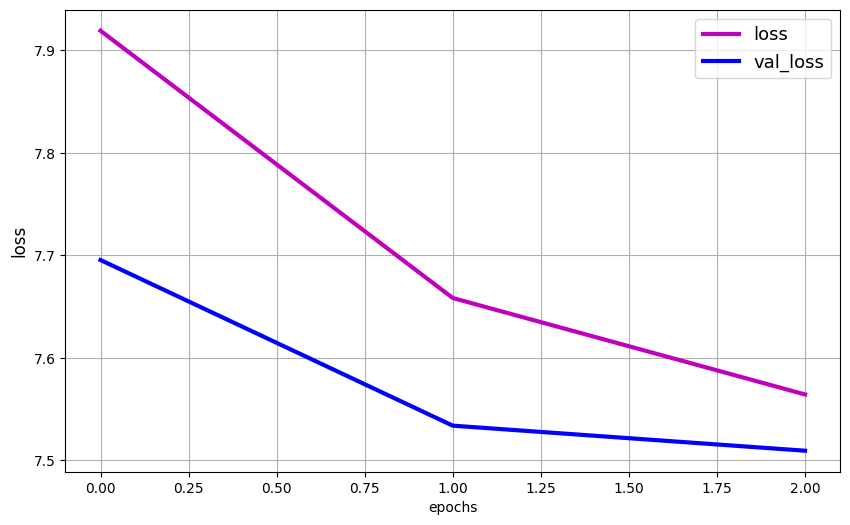

In [22]:
plt.figure(figsize=(10,6))
plt.plot(history_model.history['loss'], 'm', linewidth=3)
plt.plot(history_model.history['val_loss'], 'b', linewidth=3)
plt.legend(['loss', 'val_loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

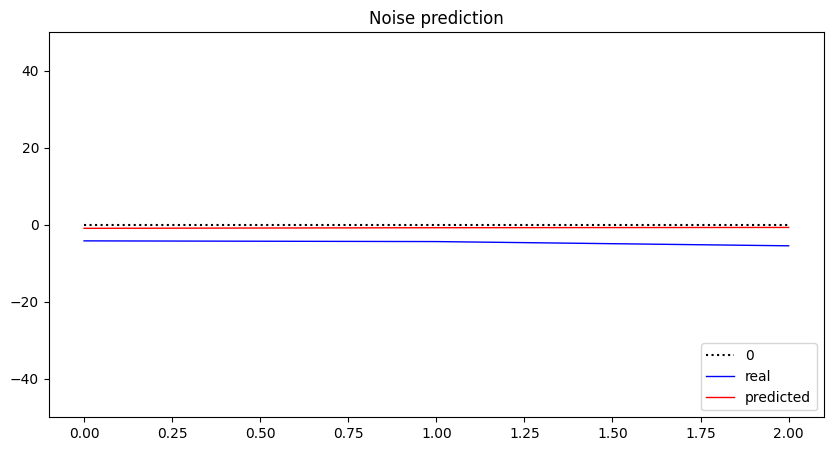

In [49]:
sample = 998

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=2, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["0","real", "predicted"], loc="lower right")
plt.title('Noise prediction')
plt.show()

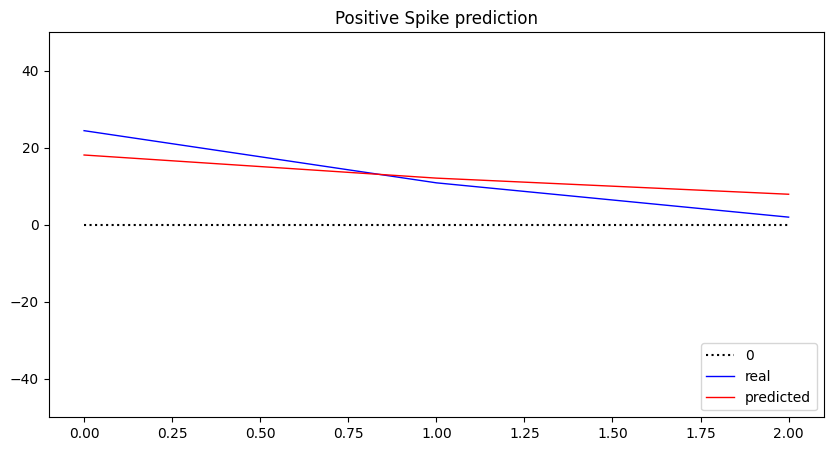

In [46]:
sample = 2937

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=2, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["0","real", "predicted"], loc="lower right")
plt.title('Positive Spike prediction')
plt.show()

In [ ]:
sample = 9926

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=2, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["0","real", "predicted"], loc="lower right")
plt.title('Positive Spike prediction')
plt.show()

In [34]:
for a in range(0, 10000):
  if max(y_test[a]) > 20:
    print(a, '- - ', y_test[a])

1154 - -  [17.18085091 28.59442513  7.59833138]
1528 - -  [20.72157205  8.88075173 -0.33555686]
2465 - -  [19.68501115 29.02339006  3.0224135 ]
2937 - -  [24.44403451 10.89422982  1.98309701]
3967 - -  [ 3.20551897  5.46381975 27.37544084]
5853 - -  [18.46327127 20.96571267 19.31776345]
9926 - -  [34.6369056  30.24237435 22.36883919]
